### Scripts Python : processing

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd

##### Columns selection (MAJ possible selon les var pertinentes au modèle)

In [ ]:
# Pour les nouvelles données
cols_kept = ['Année_construction',
            'Code_postal_(brut)',
            'Coût_total_5_usages',
            'Etiquette_DPE',
            'Etiquette_GES',
            'Hauteur_sous-plafond',
            'Logement',
            'Nombre_niveau_logement',
            'Surface_habitable_logement',
            'Type_bâtiment',
            'N°_département_(BAN)']


def select_columns(new_data, relevant_columns):

    new_data = new_data[relevant_columns]

    return new_data

##### Création de variables

In [5]:
# Pour les nouvelles données
def get_year_of_construct(value):
    year = int(value[:4])
    return year

In [6]:
# Pour les nouvelles données
def create_vars(new_data):
    if (not pd.Series(["Logement"]).isin(new_data.columns)[0]):
        new_data["Logement"] = 'neuf'

    if (not pd.Series(["Année_construction"]).isin(new_data.columns)[0]):
        from datetime import date
        new_data["Année_construction"] = new_data["Date_visite_diagnostiqueur"].apply(get_year_of_construct)

    return new_data

##### Cleaning and converting wrongly encoded data ("," vs ".")

In [7]:
# Pour les nouvelles données
def clean_and_convert(value):
    if pd.isna(value):  # Vérifie la présence de valeurs NaN ou de chaînes ' NaN'
        return value  # Préserve les NaN en tant que valeur None
    else:
        value = str(value).replace(',', '.')  # Remplace les virgules par des points
        return pd.to_numeric(value, errors='coerce')  # Conversion en valeur numérique

In [8]:
# # Pour les nouvelles données
# def cleaning_and_converting(new_data):
#     new_data.loc[:,"Besoin_ECS"] = new_data["Besoin_ECS"].apply(clean_and_convert)
#     new_data.loc[:,"Besoin_refroidissement"] = new_data["Besoin_refroidissement"].apply(clean_and_convert)
#     return new_data

##### **Embranchement 1** : Importation des données initiales et prétraitement (optimisé pour les débits internet limités)

In [ ]:
# Importation des données
logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))

In [ ]:
# Pour les anciens
logements_existants["Logement"] = "ancien"
logements_existants["Année_construction"] = logements_existants["Date_visite_diagnostiqueur"].apply(get_year_of_construct)

# Pour les neufs (et les futures données qui seront produites)
logements_neufs = create_vars(logements_neufs)

In [ ]:
logements_neufs = select_columns(logements_neufs, cols_kept)
logements_neufs.shape

(59213, 10)

In [ ]:
logements_existants = select_columns(logements_existants, cols_kept)
logements_existants.shape

(398114, 10)

In [12]:
# logements_existants = cleaning_and_converting(logements_existants)
# logements_neufs = cleaning_and_converting(logements_neufs)

In [26]:
df = pd.concat([logements_existants, logements_neufs], ignore_index=True, axis=0)

In [ ]:
# A décommenter si on veut produire le csv du dataset déjà pré-traité
df = df[df["N°_département_(BAN)"].isin([22.0,29.0,35.0,56.0])] # Sélection des codes postaux d'intérêt
df = df.drop(["N°_département_(BAN)"])
df.to_csv(os.path.join('data','processed','data_classification.csv'), index=False, sep=";", encoding="utf-8-sig")

##### **Embranchement 2** : Importation des données pré-traitées

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os 
import pandas as pd

df = pd.read_csv(os.path.join('data','processed','data_classification.csv'), sep=";")

##### Split train/test

In [9]:
def data_split(data, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0):
    from sklearn.model_selection import train_test_split

    if stratify:
        return train_test_split(data, test_size=test_size, random_state=seed, stratify=data[target])
    else:
        return train_test_split(data, test_size=test_size, random_state=seed)

In [31]:
X_train, X_test = data_split(df, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0)

##### Qualitative and quantitative data processing (after train/test split)

In [10]:
# Pour toutes les données (cf. paramètres de la fonction)

# exporter params d'un retrain pour les recharger tant que retrain=False
# exporter fit du train (original_data) tant que retrain=False (optimisation des calculs)
def quali_quanti_preprocessing(original_data, new_data):
    import pandas as pd
    
    # QUALITATIVE PREPROCESSING

    # On remplace des adresses inconnues par la chaîne "inconnu"
    # new_data['Identifiant__BAN'] = new_data['Identifiant__BAN'].fillna('inconnu')
    # new_data['Nom__rue_(BAN)'] = new_data['Nom__rue_(BAN)'].fillna('inconnu')
    # new_data['Adresse_(BAN)'] = new_data['Adresse_(BAN)'].fillna('inconnu')
    # new_data['Adresse_brute'] = new_data['Adresse_brute'].fillna('inconnu')
    
    # Le code est encodé parfois en tant que chaîne ou entier. On uniformise en chaîne de caractères
    # original_data['Code_INSEE_(BAN)'] = original_data['Code_INSEE_(BAN)'].apply(lambda x: str(x) if pd.notna(x) else x)
    # new_data['Code_INSEE_(BAN)'] = new_data['Code_INSEE_(BAN)'].apply(lambda x: str(x) if pd.notna(x) else x)

    quali_data_new = new_data.select_dtypes(include=['object'])
    for column in quali_data_new.columns:
        # Calcul de la proportion (probabilité) des modalités dans chaque variable qualitative
        proportions = original_data[column].value_counts(normalize=True)
        
        # On applique la fonction à la colonne
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        original_data[column] = original_data[column].fillna(filling)
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        quali_data_new[column] = quali_data_new[column].fillna(filling)
        

        # if retrain:
        #     quali_data_orig = original_data.select_dtypes(include=['object'])
        #     quali_data_orig[column] = quali_data_orig.apply(impute_with_proportions, axis=1)
    

    # QUANTITATIVE PREPROCESSING
    ## Missing values
    from sklearn.impute import SimpleImputer
    quanti_data_new = new_data.select_dtypes(exclude=['object'])
    imputer = SimpleImputer(strategy="median")
    original_data[quanti_data_new.columns] = imputer.fit_transform(original_data[quanti_data_new.columns])
    quanti_data_new[quanti_data_new.columns] = imputer.transform(quanti_data_new)

    import pickle as pk
    pk.dump(imputer, open(os.path.join("objects","median_imputer.pkl"), "wb"))
    
    new_data_processed = pd.concat([quali_data_new, quanti_data_new], axis=1)
    return original_data, new_data_processed

In [33]:
orig, new = quali_quanti_preprocessing(X_train, X_test)

##### Split regressors/target

In [11]:
def define_target(train, test, target="Etiquette_DPE"):
    X_train = train[train.columns.difference([target])]
    y_train = train[target]
    X_test = test[test.columns.difference([target])]
    y_test = test[target]
    return X_train, X_test, y_train, y_test

In [35]:
X_train, X_test, y_train, y_test = define_target(orig, new, target="Etiquette_DPE")

#### Split des données quanti et quali

In [36]:
def to_drop_before_model(case="classification"):
    if case=="classification":
        return ["Adresse_brute","Code_INSEE_(BAN)", "Date_fin_validité_DPE", "Date_réception_DPE", 
           "Date_visite_diagnostiqueur", "Date_établissement_DPE", "Identifiant__BAN", "N°DPE", "_geopoint"]
    elif case=="regression":
        return []
    else:
        print("Error. Only 'classification' or 'regression' supported")
        return

In [37]:
to_drop = to_drop_before_model(case="classification")

In [ ]:
def split_type(X_train, X_test, to_drop):
    quali_train = X_train.select_dtypes(include="object")
    quali_train = quali_train.drop(to_drop, axis=1) # Inutile de faire une ACM sur une variable avec autant de modalités possibles
    quali_test = X_test.select_dtypes(include="object")
    quali_test = quali_test.drop(to_drop, axis=1) # Inutile de faire une ACM sur une variable avec autant de modalités possibles

    quantit_train = X_train.select_dtypes(exclude="object")
    quantit_test = X_test.select_dtypes(exclude="object")

    from sklearn.preprocessing import OneHotEncoder

    encoder = OneHotEncoder()

    encoder.fit(pd.concat([quali_train, quali_test], axis=0))
    #print(encoder.get_feature_names_out(quali_train.columns))
    quali_train_encoded = encoder.transform(quali_train).toarray()
    qualit_train = pd.DataFrame(quali_train_encoded, index=quali_train.index, columns=encoder.get_feature_names_out(quali_train.columns))
    quali_test_encoded = encoder.transform(quali_test).toarray()
    qualit_test = pd.DataFrame(quali_test_encoded, index=quali_test.index, columns=encoder.get_feature_names_out(quali_test.columns))
    # print(quali_train.apply(pd.unique).apply(len))

    import pickle as pk
    pk.dump(encoder, open(os.path.join("objects","OHE_classification.pkl"), "wb"))

    return qualit_train, qualit_test, quantit_train, quantit_test

In [37]:
quali_train, quali_test, quanti_train, quanti_test = split_type(X_train, X_test, to_drop=[])

#### ACM

In [ ]:
def chunking_MCA(quali_train, quali_test, n_components, n_iter, seed, chunk_size):
    # Exportation en csv pour le chunking
    quali_train.to_csv(os.path.join('data','processed','quali_train.csv'), index=False, sep=";", encoding="utf-8-sig")
    quali_test.to_csv(os.path.join('data','processed','quali_test.csv'), index=False, sep=";", encoding="utf-8-sig")

    import prince

    mca = prince.MCA(
        n_components=n_components,
        n_iter=n_iter,
        copy=False,
        check_input=False,
        random_state=seed,
        engine="sklearn",
        handle_unknown="error"  # paramètre identique à celui de sklearn.preprocessing.OneHotEncoder
    )

    print("MCA : fitting to train set")
    quali_train_mca_lst = []
    i = 0
    for chunk in pd.read_csv(os.path.join('data','processed','quali_train.csv'), sep=';', chunksize=chunk_size):
        mca = mca.fit(chunk)
        quali_train_mca_lst.append(mca.transform(chunk))
        i += 1
        if i%100==0:
            print((i*chunk_size)/quali_train.shape[0])
    
    quali_train_mca = pd.DataFrame()
    for elem in quali_train_mca_lst:
        quali_train_mca = pd.concat([quali_train_mca, pd.DataFrame(elem)], axis=0, ignore_index=True)

    print("MCA : transforming test set")

    quali_test_mca_lst = []
    i = 0
    for chunk in pd.read_csv(os.path.join('data','processed','quali_test.csv'), sep=';', chunksize=chunk_size):
        quali_test_mca_lst.append(mca.transform(chunk))
        i += 1
        if i%50==0:
            print((i*chunk_size)/quali_test.shape[0])
    
    quali_test_mca = pd.DataFrame()
    for elem in quali_test_mca_lst:
        quali_test_mca = pd.concat([quali_test_mca, pd.DataFrame(elem)], axis=0, ignore_index=True)
    
    os.remove(os.path.join('data','processed','quali_train.csv'))
    os.remove(os.path.join('data','processed','quali_test.csv'))

    return quali_train_mca, quali_test_mca

In [46]:
quali_train_mca, quali_test_mca =  chunking_MCA(quali_train, quali_test, n_components=10, n_iter=10, seed=0, chunk_size=1000)

MCA : fitting to train set
0.312375049980008
0.624750099960016
0.9371251499400239
MCA : transforming test set
0.3644341431059993
0.7288682862119986


In [13]:
def merge_type_back(quali_train_mca, quali_test_mca, quanti_train, quanti_test, train_index, test_index):
    # Convert colnames to str
    quali_train_mca.columns = quali_train_mca.columns.astype(str)
    quali_test_mca.columns = quali_test_mca.columns.astype(str)

    quali_train_mca.set_index(train_index, inplace=True)
    quali_test_mca.set_index(test_index, inplace=True)

    # Concaténer, quali_train et quanti_train de même avec test
    X_train_mca = pd.concat([quanti_train, quali_train_mca], axis=1)
    X_test_mca = pd.concat([quanti_test, quali_test_mca], axis=1)

    return X_train_mca, X_test_mca

In [39]:
X_train_mca, X_test_mca = merge_type_back(quali_train, quali_test, quanti_train, quanti_test, X_train.index, X_test.index)

### Standardisation

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_mca_scaled = pd.DataFrame(scaler.fit_transform(X_train_mca), index=X_train_mca.index, columns=X_train_mca.columns)
X_test_mca_scaled = pd.DataFrame(scaler.transform(X_test_mca), index=X_test_mca.index, columns=X_test_mca.columns)

### Feature selection

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=0, verbose=1)
rf.fit(X_train_mca, y_train)
y_pred = rf.predict(X_test_mca)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s


In [83]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00      8402
           B       0.99      1.00      1.00      7973
           C       1.00      1.00      1.00     41301
           D       1.00      1.00      1.00     38342
           E       0.99      1.00      0.99     24184
           F       0.99      0.98      0.99     10051
           G       0.99      0.99      0.99      6946

    accuracy                           1.00    137199
   macro avg       0.99      0.99      0.99    137199
weighted avg       1.00      1.00      1.00    137199



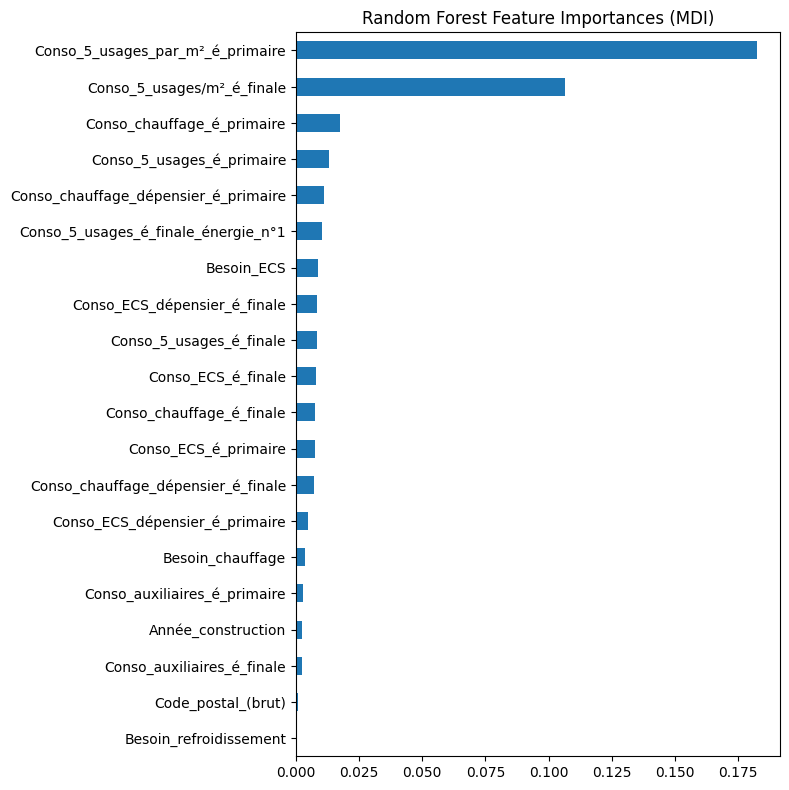

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

feature_names = rf.feature_names_in_[:20]

mdi_importances = pd.Series(
    rf.feature_importances_[:20], index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

### Modélisation

In [ ]:
# vars = ['Année_construction',
#         'Surface_habitable_logement',
#         'Coût_total_5_usages',
#         'Etiquette_GES',
#         'Code_postal_(brut)',
#         'Logement',
#         'Type_bâtiment',
#         'Hauteur_sous-plafond',
#         'Nombre_niveau_logement',
#         'Etiquette_DPE'
#         ]
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder()

# encoder.fit(X_train[vars])

In [40]:
vars = ['Année_construction',
        'Code_postal_(brut)',
        'Coût_total_5_usages',
        'Hauteur_sous-plafond',
        'Nombre_niveau_logement',
        'Surface_habitable_logement',
        'Etiquette_GES_A',
        'Etiquette_GES_B',
        # 'Etiquette_GES_C',
        'Etiquette_GES_D',
        'Etiquette_GES_E',
        'Etiquette_GES_F',
        'Etiquette_GES_G',
        'Logement_neuf',
        # 'Type_bâtiment_appartement',
        'Type_bâtiment_immeuble',
        'Type_bâtiment_maison'
        ]

In [41]:
X_train_mca[vars].corr()

,Année_construction,Code_postal_(brut),Coût_total_5_usages,Hauteur_sous-plafond,Nombre_niveau_logement,Surface_habitable_logement,Etiquette_GES_A,Etiquette_GES_B,Etiquette_GES_D,Etiquette_GES_E,Etiquette_GES_F,Etiquette_GES_G,Logement_neuf,Type_bâtiment_immeuble,Type_bâtiment_maison
Année_construction,1.000000,-0.027940,0.016004,-0.003179,-0.020551,-0.016078,0.022530,-0.007684,0.000034,-0.029708,-0.035920,-0.028122,-0.038695,0.050447,-0.049764
Code_postal_(brut),-0.027940,1.000000,-0.014812,-0.000544,0.060865,0.005738,0.044083,-0.002199,-0.041315,-0.013974,-0.025116,-0.015621,0.039767,0.007868,-0.008857
Coût_total_5_usages,0.016004,-0.014812,1.000000,-0.000460,0.031279,0.220637,-0.112020,-0.022349,0.046724,0.080113,0.104011,0.091291,-0.123987,0.540067,0.093035
Hauteur_sous-plafond,-0.003179,-0.000544,-0.000460,1.000000,-0.001066,-0.000070,0.001702,-0.002326,-0.001078,-0.000712,-0.000223,-0.000262,0.003745,-0.000453,-0.000615
Nombre_niveau_logement,-0.020551,0.060865,0.031279,-0.001066,1.000000,0.098197,-0.048483,0.000766,-0.007031,0.031098,0.036122,0.017283,-0.078165,-0.048165,0.154497
Surface_habitable_logement,-0.016078,0.005738,0.220637,-0.000070,0.098197,1.000000,0.071088,-0.058454,0.011158,0.041418,0.044502,0.013516,0.061643,0.137711,0.303640
Etiquette_GES_A,0.022530,0.044083,-0.112020,0.001702,-0.048483,0.071088,1.000000,-0.307593,-0.189962,-0.128719,-0.095224,-0.061225,0.309051,-0.029121,0.126894
Etiquette_GES_B,-0.007684,-0.002199,-0.022349,-0.002326,0.000766,-0.058454,-0.307593,1.000000,-0.233065,-0.157926,-0.116831,-0.075117,-0.118966,-0.017587,0.036698
Etiquette_GES_D,0.000034,-0.041315,0.046724,-0.001078,-0.007031,0.011158,-0.189962,-0.233065,1.000000,-0.097531,-0.072152,-0.046391,-0.145031,0.006884,-0.061623
Etiquette_GES_E,-0.029708,-0.013974,0.080113,-0.000712,0.031098,0.041418,-0.128719,-0.157926,-0.097531,1.000000,-0.048891,-0.031435,-0.098542,-0.009722,0.062845


In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, min_samples_split=5, max_depth=None, random_state=0, verbose=1)
rf.fit(X_train_mca[vars], y_train)
y_pred = rf.predict(X_test_mca[vars])

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier()
cv = StratifiedKFold(5)
params = {'n_estimators': [100],
          'min_samples_split': [5],
          'max_depth': [20, None]}
grid = GridSearchCV(rf, param_grid=params, scoring="accuracy", cv=cv, verbose=2)
grid.fit(X_train_mca[vars], y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  48.2s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  46.7s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  45.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  45.7s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  46.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  53.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  52.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  52.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  51.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  52.2s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [20, None], 'min_samples_split': [5],
                         'n_estimators': [100]},
             scoring='accuracy', verbose=2)

In [ ]:
# Quali OHE
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.98      0.97      0.97      8402
           B       0.91      0.85      0.88      7973
           C       0.94      0.95      0.94     41301
           D       0.91      0.93      0.92     38342
           E       0.89      0.89      0.89     24184
           F       0.86      0.81      0.83     10051
           G       0.93      0.87      0.90      6946

    accuracy                           0.91    137199
   macro avg       0.91      0.90      0.90    137199
weighted avg       0.91      0.91      0.91    137199



In [ ]:
# Sans quali OHE
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.94      0.95      8402
           B       0.87      0.81      0.84      7973
           C       0.92      0.94      0.93     41301
           D       0.89      0.91      0.90     38342
           E       0.87      0.85      0.86     24184
           F       0.83      0.78      0.80     10051
           G       0.90      0.84      0.87      6946

    accuracy                           0.89    137199
   macro avg       0.89      0.87      0.88    137199
weighted avg       0.89      0.89      0.89    137199



In [ ]:
# Emission_GES_ECS
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.97      0.97      0.97      8402
           B       0.91      0.87      0.89      7973
           C       0.94      0.95      0.95     41301
           D       0.90      0.92      0.91     38342
           E       0.88      0.87      0.88     24184
           F       0.84      0.80      0.82     10051
           G       0.92      0.85      0.88      6946

    accuracy                           0.91    137199
   macro avg       0.91      0.89      0.90    137199
weighted avg       0.91      0.91      0.91    137199



In [ ]:
# Etiquettes GES A + G
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.97      0.98      0.97      8402
           B       0.92      0.87      0.90      7973
           C       0.95      0.96      0.95     41301
           D       0.91      0.92      0.92     38342
           E       0.88      0.87      0.88     24184
           F       0.85      0.82      0.83     10051
           G       0.95      0.86      0.90      6946

    accuracy                           0.92    137199
   macro avg       0.92      0.90      0.91    137199
weighted avg       0.92      0.92      0.92    137199



In [66]:
# Etiquettes GES A - G
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.97      0.96      8402
           B       0.92      0.90      0.91      7973
           C       0.94      0.98      0.96     41301
           D       0.91      0.90      0.91     38342
           E       0.89      0.88      0.88     24184
           F       0.86      0.84      0.85     10051
           G       0.91      0.82      0.87      6946

    accuracy                           0.92    137199
   macro avg       0.91      0.90      0.90    137199
weighted avg       0.92      0.92      0.92    137199



In [ ]:
# 50 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.97      0.96      8402
           B       0.92      0.90      0.91      7973
           C       0.94      0.98      0.96     41301
           D       0.91      0.90      0.91     38342
           E       0.89      0.88      0.88     24184
           F       0.86      0.83      0.84     10051
           G       0.91      0.82      0.86      6946

    accuracy                           0.92    137199
   macro avg       0.91      0.90      0.90    137199
weighted avg       0.91      0.92      0.91    137199



In [45]:
# 20 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96      8291
           B       0.92      0.89      0.90      7865
           C       0.94      0.98      0.96     40854
           D       0.90      0.90      0.90     38068
           E       0.89      0.87      0.88     24065
           F       0.85      0.83      0.84     10011
           G       0.89      0.81      0.85      6911

    accuracy                           0.91    136065
   macro avg       0.91      0.89      0.90    136065
weighted avg       0.91      0.91      0.91    136065



In [47]:
# 10 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.95      0.96      0.96      8291
           B       0.91      0.88      0.90      7865
           C       0.94      0.97      0.95     40854
           D       0.90      0.89      0.90     38068
           E       0.88      0.86      0.87     24065
           F       0.85      0.82      0.83     10011
           G       0.88      0.81      0.84      6911

    accuracy                           0.91    136065
   macro avg       0.90      0.89      0.89    136065
weighted avg       0.91      0.91      0.91    136065



In [43]:
# 5 arbres
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.95      0.96      0.95      8291
           B       0.91      0.87      0.89      7865
           C       0.93      0.97      0.95     40854
           D       0.89      0.88      0.89     38068
           E       0.87      0.85      0.86     24065
           F       0.83      0.81      0.82     10011
           G       0.87      0.79      0.83      6911

    accuracy                           0.90    136065
   macro avg       0.89      0.88      0.88    136065
weighted avg       0.90      0.90      0.90    136065



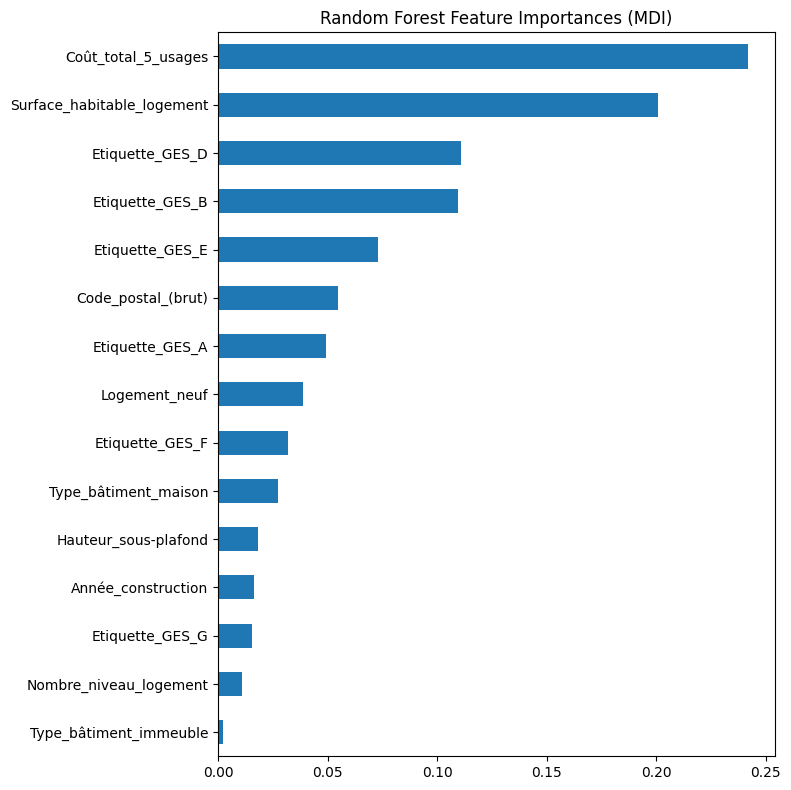

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

feature_names = rf.feature_names_in_

mdi_importances = pd.Series(
    rf.feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

In [49]:
import pickle as pk

pk.dump(rf, open(os.path.join("models","rf_tuned_classification.pkl"), "wb"))

In [54]:
# TEST PIPELINE
import pandas as pd
from pipeline import Pipeline_classification

new = pd.DataFrame([{"Année_construction":2024,
                     "Surface_habitable_logement":200,
                     "Coût_total_5_usages":10000,
                     "Etiquette_GES":"B",
                     "Code_postal_(brut)":35660,
                     "Logement":"neuf",
                     "Type_bâtiment":"maison",
                     "Hauteur_sous-plafond":3,
                     "Nombre_niveau_logement":2
                     }])

Pipeline_classification(new)

['E']


### Création du csv pour la carte des données

In [ ]:
# Importation des données
logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))

C:\Users\DELL\AppData\Local\Temp\ipykernel_10640\1169846585.py:2: DtypeWarning: Columns (80,100,111,112,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
C:\Users\DELL\AppData\Local\Temp\ipykernel_10640\1169846585.py:3: DtypeWarning: Columns (159,191,202,208,214,215,218,219,220,221,228,232) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))


In [63]:
df = pd.concat([logements_existants, logements_neufs], ignore_index=True, axis=0)


df[["lat","lon"]] = df["_geopoint"].str.split(",", expand=True)
df["lon"] = pd.to_numeric(df["lon"])
df["lat"] = pd.to_numeric(df["lat"])
df = df[["lon","lat","Type_bâtiment","Surface_habitable_logement","Etiquette_DPE"]]

C:\Users\DELL\AppData\Local\Temp\ipykernel_10640\3804064002.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["lat","lon"]] = df["_geopoint"].str.split(",", expand=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_10640\3804064002.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["lat","lon"]] = df["_geopoint"].str.split(",", expand=True)


In [64]:
# Preprocessing des données map

def map_preprocessing(data):
    import pandas as pd
    
    # QUALITATIVE PREPROCESSING

    quali_data = data.select_dtypes(include=['object'])
    for column in quali_data.columns:
        # Calcul de la proportion (probabilité) des modalités dans chaque variable qualitative
        proportions = data[column].value_counts(normalize=True)
        
        # On applique la fonction à la colonne
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        data[column] = data[column].fillna(filling)
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        quali_data[column] = quali_data[column].fillna(filling)
    

    # QUANTITATIVE PREPROCESSING
    ## Missing values
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="median")

    quanti_data = data.select_dtypes(exclude=['object'])
    quanti_data[quanti_data.columns] = imputer.fit_transform(quanti_data)

    new_data_processed = pd.concat([quali_data, quanti_data], axis=1)
    return new_data_processed

In [65]:
data_map = map_preprocessing(df)

In [66]:
data_map.to_csv(os.path.join("data","processed","data_map.csv"),index=False, sep=";", encoding="utf-8-sig")

In [76]:
# TEST MAP
import pandas as pd
import os
from mapping import generate_map

df = pd.read_csv(os.path.join("data","processed","data_map.csv"), sep=";", encoding="utf-8-sig")

generate_map(df.sample(10000))

### Régression

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import os
# Importation des données
logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))

C:\Users\DELL\AppData\Local\Temp\ipykernel_7804\3189487528.py:4: DtypeWarning: Columns (80,100,111,112,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_neufs = pd.read_csv(os.path.join('data','raw','neufs.csv'))
C:\Users\DELL\AppData\Local\Temp\ipykernel_7804\3189487528.py:5: DtypeWarning: Columns (159,191,202,208,214,215,218,219,220,221,228,232) have mixed types. Specify dtype option on import or set low_memory=False.
  logements_existants = pd.read_csv(os.path.join('data','raw','existents.csv'))


In [15]:
# Pour les nouvelles données
def get_year_of_construct(value):
    year = int(value[:4])
    return year

In [16]:
# Pour les nouvelles données
def create_vars(new_data):
    if (not pd.Series(["Logement"]).isin(new_data.columns)[0]):
        new_data["Logement"] = 'neuf'

    if (not pd.Series(["Année_construction"]).isin(new_data.columns)[0]):
        from datetime import date
        new_data["Année_construction"] = new_data["Date_visite_diagnostiqueur"].apply(get_year_of_construct)

    return new_data

In [17]:
# Pour les anciens
logements_existants["Logement"] = "ancien"
logements_existants["Année_construction"] = logements_existants["Date_visite_diagnostiqueur"].apply(get_year_of_construct)

# Pour les neufs (et les futures données qui seront produites)
logements_neufs = create_vars(logements_neufs)

In [18]:
def select_columns(new_data, relevant_columns):

    new_data = new_data[relevant_columns]

    return new_data

cols_kept = ['Année_construction',
            'Code_postal_(brut)',
            'Coût_total_5_usages',
            'Etiquette_DPE',
            # 'Etiquette_GES',
            'Hauteur_sous-plafond',
            'Logement',
            'Nombre_niveau_logement',
            'Surface_habitable_logement',
            'Type_bâtiment',
            'N°_département_(BAN)']

logements_neufs = select_columns(logements_neufs, cols_kept)
logements_neufs.shape

(59213, 10)

In [19]:
logements_existants = select_columns(logements_existants, cols_kept)
logements_existants.shape

(398114, 10)

In [20]:
# logements_existants = cleaning_and_converting(logements_existants)
# logements_neufs = cleaning_and_converting(logements_neufs)

In [21]:
df = pd.concat([logements_existants, logements_neufs], ignore_index=True, axis=0)

In [22]:
# A décommenter si on veut produire le csv du dataset déjà pré-traité
df = df[df["N°_département_(BAN)"].isin([22.0,29.0,35.0,56.0])] # Sélection des codes postaux d'intérêt
df = df.drop(["N°_département_(BAN)"],axis=1)
df.to_csv(os.path.join('data','processed','data_regression.csv'), index=False, sep=";", encoding="utf-8-sig")

In [23]:
def data_split(data, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0):
    from sklearn.model_selection import train_test_split

    if stratify:
        return train_test_split(data, test_size=test_size, random_state=seed, stratify=data[target])
    else:
        return train_test_split(data, test_size=test_size, random_state=seed)

In [24]:
X_train, X_test = data_split(df, target="Coût_total_5_usages", test_size=0.3, stratify=False, seed=0)

##### Qualitative and quantitative data processing (after train/test split)

In [25]:
# Pour toutes les données (cf. paramètres de la fonction)

# exporter params d'un retrain pour les recharger tant que retrain=False
# exporter fit du train (original_data) tant que retrain=False (optimisation des calculs)
def quali_quanti_preprocessing(original_data, new_data):
    import pandas as pd
    
    # QUALITATIVE PREPROCESSING

    # On remplace des adresses inconnues par la chaîne "inconnu"
    # new_data['Identifiant__BAN'] = new_data['Identifiant__BAN'].fillna('inconnu')
    # new_data['Nom__rue_(BAN)'] = new_data['Nom__rue_(BAN)'].fillna('inconnu')
    # new_data['Adresse_(BAN)'] = new_data['Adresse_(BAN)'].fillna('inconnu')
    # new_data['Adresse_brute'] = new_data['Adresse_brute'].fillna('inconnu')
    
    # Le code est encodé parfois en tant que chaîne ou entier. On uniformise en chaîne de caractères
    # original_data['Code_INSEE_(BAN)'] = original_data['Code_INSEE_(BAN)'].apply(lambda x: str(x) if pd.notna(x) else x)
    # new_data['Code_INSEE_(BAN)'] = new_data['Code_INSEE_(BAN)'].apply(lambda x: str(x) if pd.notna(x) else x)

    quali_data_new = new_data.select_dtypes(include=['object'])
    for column in quali_data_new.columns:
        # Calcul de la proportion (probabilité) des modalités dans chaque variable qualitative
        proportions = original_data[column].value_counts(normalize=True)
        
        # On applique la fonction à la colonne
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        original_data[column] = original_data[column].fillna(filling)
        filling = proportions.sample(weights=proportions, replace=True).index[0]
        quali_data_new[column] = quali_data_new[column].fillna(filling)
        

        # if retrain:
        #     quali_data_orig = original_data.select_dtypes(include=['object'])
        #     quali_data_orig[column] = quali_data_orig.apply(impute_with_proportions, axis=1)
    

    # QUANTITATIVE PREPROCESSING
    ## Missing values
    from sklearn.impute import SimpleImputer
    quanti_data_new = new_data.select_dtypes(exclude=['object'])
    imputer = SimpleImputer(strategy="median")
    original_data[quanti_data_new.columns] = imputer.fit_transform(original_data[quanti_data_new.columns])
    quanti_data_new[quanti_data_new.columns] = imputer.transform(quanti_data_new)

    import pickle as pk
    pk.dump(imputer, open(os.path.join("objects","median_imputer_regression.pkl"), "wb"))
    
    new_data_processed = pd.concat([quali_data_new, quanti_data_new], axis=1)
    return original_data, new_data_processed

In [26]:
orig, new = quali_quanti_preprocessing(X_train, X_test)

##### Split regressors/target

In [27]:
def define_target(train, test, target="Etiquette_DPE"):
    X_train = train[train.columns.difference([target])]
    y_train = train[target]
    X_test = test[test.columns.difference([target])]
    y_test = test[target]
    return X_train, X_test, y_train, y_test

In [28]:
X_train, X_test, y_train, y_test = define_target(orig, new, target="Coût_total_5_usages")

#### Split des données quanti et quali

In [29]:
def split_type(X_train, X_test, to_drop):
    quali_train = X_train.select_dtypes(include="object")
    quali_train = quali_train.drop(to_drop, axis=1) # Inutile de faire une ACM sur une variable avec autant de modalités possibles
    quali_test = X_test.select_dtypes(include="object")
    quali_test = quali_test.drop(to_drop, axis=1) # Inutile de faire une ACM sur une variable avec autant de modalités possibles

    quantit_train = X_train.select_dtypes(exclude="object")
    quantit_test = X_test.select_dtypes(exclude="object")

    from sklearn.preprocessing import OneHotEncoder

    encoder = OneHotEncoder()

    encoder.fit(pd.concat([quali_train, quali_test], axis=0))
    #print(encoder.get_feature_names_out(quali_train.columns))
    quali_train_encoded = encoder.transform(quali_train).toarray()
    qualit_train = pd.DataFrame(quali_train_encoded, index=quali_train.index, columns=encoder.get_feature_names_out(quali_train.columns))
    quali_test_encoded = encoder.transform(quali_test).toarray()
    qualit_test = pd.DataFrame(quali_test_encoded, index=quali_test.index, columns=encoder.get_feature_names_out(quali_test.columns))
    # print(quali_train.apply(pd.unique).apply(len))

    import pickle as pk
    pk.dump(encoder, open(os.path.join("objects","OHE_regression.pkl"), "wb"))

    return qualit_train, qualit_test, quantit_train, quantit_test

In [30]:
quali_train, quali_test, quanti_train, quanti_test = split_type(X_train, X_test, to_drop=[])

In [31]:
def merge_type_back(quali_train_mca, quali_test_mca, quanti_train, quanti_test, train_index, test_index):
    # Convert colnames to str
    quali_train_mca.columns = quali_train_mca.columns.astype(str)
    quali_test_mca.columns = quali_test_mca.columns.astype(str)

    quali_train_mca.set_index(train_index, inplace=True)
    quali_test_mca.set_index(test_index, inplace=True)

    # Concaténer, quali_train et quanti_train de même avec test
    X_train_mca = pd.concat([quanti_train, quali_train_mca], axis=1)
    X_test_mca = pd.concat([quanti_test, quali_test_mca], axis=1)

    return X_train_mca, X_test_mca

In [32]:
X_train_mca, X_test_mca = merge_type_back(quali_train, quali_test, quanti_train, quanti_test, X_train.index, X_test.index)

In [37]:
vars = ['Année_construction',
        'Code_postal_(brut)',
        'Hauteur_sous-plafond',
        'Nombre_niveau_logement',
        'Surface_habitable_logement',
        'Etiquette_DPE_A',
        'Etiquette_DPE_B',
        # 'Etiquette_DPE_C',
        'Etiquette_DPE_D',
        'Etiquette_DPE_E',
        'Etiquette_DPE_F',
        'Etiquette_DPE_G',
        # 'Etiquette_GES_A',
        # 'Etiquette_GES_B',
        # # 'Etiquette_GES_C',
        # 'Etiquette_GES_D',
        # 'Etiquette_GES_E',
        # 'Etiquette_GES_F',
        # 'Etiquette_GES_G',
        'Logement_neuf',
        # 'Type_bâtiment_appartement',
        'Type_bâtiment_immeuble',
        'Type_bâtiment_maison'
        ]

In [38]:
X_train_mca[vars].corr()

,Année_construction,Code_postal_(brut),Hauteur_sous-plafond,Nombre_niveau_logement,Surface_habitable_logement,Etiquette_DPE_A,Etiquette_DPE_B,Etiquette_DPE_D,Etiquette_DPE_E,Etiquette_DPE_F,Etiquette_DPE_G,Logement_neuf,Type_bâtiment_immeuble,Type_bâtiment_maison
Année_construction,1.000000,-0.024722,-0.003836,-0.010271,-0.015274,0.000129,0.011990,0.013671,-0.029082,-0.061118,-0.062205,-0.035617,0.049793,-0.050993
Code_postal_(brut),-0.024722,1.000000,-0.000418,0.019212,0.005621,0.041404,0.008246,-0.025586,-0.020707,-0.027716,-0.031438,0.050553,0.007308,-0.016369
Hauteur_sous-plafond,-0.003836,-0.000418,1.000000,-0.000373,0.000264,0.005769,-0.001234,-0.001938,-0.001745,0.005425,-0.000410,0.004094,-0.000421,-0.000155
Nombre_niveau_logement,-0.010271,0.019212,-0.000373,1.000000,0.031263,-0.025374,0.001433,-0.004743,0.009941,0.007555,0.002338,-0.025407,-0.015244,0.049545
Surface_habitable_logement,-0.015274,0.005621,0.000264,0.031263,1.000000,0.104502,0.040168,-0.024427,-0.021305,0.006209,-0.026946,0.061370,0.142692,0.298326
Etiquette_DPE_A,0.000129,0.041404,0.005769,-0.025374,0.104502,1.000000,-0.063577,-0.159517,-0.118593,-0.071947,-0.059202,0.560687,-0.023595,0.221285
Etiquette_DPE_B,0.011990,0.008246,-0.001234,0.001433,0.040168,-0.063577,1.000000,-0.154714,-0.115023,-0.069781,-0.057420,0.276068,-0.004309,-0.003658
Etiquette_DPE_D,0.013671,-0.025586,-0.001938,-0.004743,-0.024427,-0.159517,-0.154714,1.000000,-0.288595,-0.175081,-0.144067,-0.239033,-0.007571,-0.045460
Etiquette_DPE_E,-0.029082,-0.020707,-0.001745,0.009941,-0.021305,-0.118593,-0.115023,-0.288595,1.000000,-0.130165,-0.107108,-0.178504,-0.010972,0.080939
Etiquette_DPE_F,-0.061118,-0.027716,0.005425,0.007555,0.006209,-0.071947,-0.069781,-0.175081,-0.130165,1.000000,-0.064979,-0.108339,-0.012072,0.113441


In [113]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, min_samples_split=5, max_depth=None, random_state=0, verbose=1)
rf.fit(X_train_mca[vars], y_train)
y_pred = rf.predict(X_test_mca[vars])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.6s


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

rf = RandomForestRegressor()
cv = KFold(5)
params = {'n_estimators': [10,50,100],
          'min_samples_split': [5],
          'max_depth': [10, None],
          'criterion': ["absolute_error"]}
grid = GridSearchCV(rf, param_grid=params, scoring="neg_mean_absolute_error", cv=cv, verbose=2)
grid.fit(X_train_mca[vars], y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [114]:
# Sans DPE
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

print(mean_absolute_error(y_test, y_pred))
print(root_mean_squared_error(y_test, y_pred))

331.675860284776
1857.4088016991964


In [93]:
# Avec DPE
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

print(mean_absolute_error(y_test, y_pred))
print(root_mean_squared_error(y_test, y_pred))

266.6571519393357
1801.106436272338


In [ ]:
# Reprendre le modèle de RF et l'Entraîner avec les meilleurs paramètres

count    456005.000000
mean       1438.341863
std        2703.442178
min          16.400000
25%         652.000000
50%        1022.400000
75%        1622.600000
max      355329.300000
Name: Coût_total_5_usages, dtype: float64